### Many-body Entanglement and Tensor Networks
Tutorials based on the 2017 Perimeter Scholar International Condensed Matter Review course taught by Guifre Vidal

# <span style="color:#0C45A9">Python tutorial 7</span>

In this tutorial we will work within the free fermion formalism. We will study the energy and ground-state entanglement for two free fermionic systems: one with two zero modes and one with more zero modes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eig

import warnings
warnings.filterwarnings('ignore')

## 7.1. Free fermionic system: two zero-modes

As in the previous tutorial we aim to simultaneously diagonalise the $N\times N$ matrix $A$ and transfer matrix $T$.<br>
We will observe that free fermions have two zero modes, compared to one zero mode in free Majorana systems. The long distance behaviour of the free fermion model is dominated by the dispersion in the neighbourhood of the zero modes. Therefore, the free fermion system is really like having two copies of a free Majorana model. The results are in the same universality class as the $XX$ model.

### 7.1.1. Functions for Hamiltonian and Translation operators

#### b) Building $N\times N$ Hamiltonian matrix $A$ 
Particle perserving quadratic fermionic Hamiltonian.

In [2]:
def build_matrix_A(N, bc=1): # bc=1 (default) for PBC and bc=-1 for APBC
    A = np.zeros((N, N)) 
    for n in range(N-1):
        A[n, n+1] = -1
        A[n+1, n] = -1
    A[N-1,0] = -bc
    A[0,N-1] = -bc
    return A

#### a) Building translation operator $T_f$

In [3]:
def build_T_operator(N, bc=1): # bc=1 (default) for PBC and bc=-1 for APBC
    T_op = np.zeros((N,N))
    for n in range(N-1):
        T_op[n,n+1] = 1
        
    T_op[N-1,0] = bc
    return T_op

### 7.1.2. Diagonalization of  $A$ and $T$.

We obtain the single particle energies $e_\alpha$ and momenta $k_{\alpha}$.

In [4]:
def diagonalise_A_T(A, T_op):
    N = int(np.shape(A)[0])
    M = A.dot(np.eye(N) + 0.13*T_op)+0.05*T_op
    D, U = eig(M)
    
    e = np.real(np.diag((U.conj().T).dot(A).dot(U)))
    k = np.angle(np.diag((U.conj().T).dot(T_op).dot(U)))
    
    #sort from smaller to largest
    ord_idx = np.argsort(e)
    e = e[ord_idx]
    k = k[ord_idx]
    
    return e, k

In [5]:
N = 400

#PERIODIC BC
A_pbc = build_matrix_A(N, bc = 1)
T_pbc = build_T_operator(N, bc = 1)
e_pbc, k_pbc = diagonalise_A_T(A_pbc, T_pbc)
#APERIODIC BC
A_apbc = build_matrix_A(N, bc = -1)
T_apbc = build_T_operator(N, bc = -1)
e_apbc, k_apbc = diagonalise_A_T(A_apbc, T_apbc)

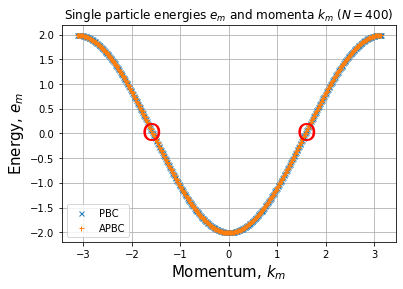

In [6]:
plt.title("Single particle energies $e_m$ and momenta $k_m$ ($N=$%s)" %(N))
plt.grid()
plt.ylabel(r"Energy, $e_m$", fontsize = 15)
plt.xlabel(r"Momentum, $k_m$", fontsize = 15)
plt.plot(k_pbc, e_pbc, 'x', ms=5, label = 'PBC')
plt.plot(k_apbc, e_apbc, '+', ms=5, label = 'APBC')
plt.text(-1.8,-0.15,"O", fontsize=25, color='red')
plt.text(1.4,-0.15,"O", fontsize=25, color='red')
plt.legend()
plt.show()

### 7.1.3. Correlation matrix $M$ for ground-state ($N$ sites)

In [7]:
def obtain_M(A, T_op):
    N = int(np.shape(A)[0])
    M = A.dot(np.eye(N) + 0.13*T_op)+0.05*T_op
    D, U = eig(M)
    
    e = np.real(np.diag((U.conj().T).dot(A).dot(U)))
    k = np.angle(np.diag((U.conj().T).dot(T_op).dot(U)))
    
    ord_idx = np.argsort(e)
    e = e[ord_idx]
    k = k[ord_idx]
    U = U[:, ord_idx]
    
    M = (U.dot(np.diag(np.sign(e)))).dot(U.conj().T)
    
    return M

In [8]:
A_apbc = build_matrix_A(N, bc = -1)
T_apbc = build_T_operator(N, bc = -1)

M = obtain_M(A_apbc, T_apbc)

print("Is M successfully real?", np.allclose(M, np.real(M)))
M = np.real(M) #cleaning neglible imaginary part
print("Is M successfully symmetric?", np.allclose(M, (M+M.conj().T)/2))

Is M successfully real? True
Is M successfully symmetric? True


### 7.1.4. Reduced correlation matrix $M^A$

In [9]:
L_max = N//2
L_s = np.arange(1,L_max+1)

M_A = M[0:L_max, 0:L_max]

### 7.1.5. Entanglement entropy in ground-state

This model belongs to a different universality class with respects to the critical Ising model. The central charge in this model is $c = \frac{\#zero\;modes}{2} = \frac{2}{2}=1$.<br>

In [10]:
def ent_entropy_fermi(M):
    p = np.shape(M)[0]
    entropy = np.zeros(p)
    for n in range(p+1):
        M_red = M[:n, :n]
        u,v = eig(M_red)
        for m in range(n):
            x = u[m]
            if abs(x) < 1:
                entropy[n-1] -= (1+x)/2*np.log2((1+x)/2) + (1-x)/2*np.log2((1-x)/2)
            elif abs(x) > 1+1e-5:
                print("warning: (absolute) single particle eigenvalue > 1")
    return entropy

In [11]:
entropy_numerical = ent_entropy_fermi(M_A)

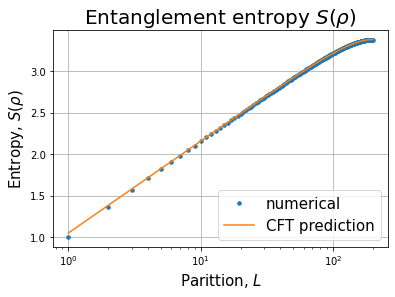

In [12]:
cft_ent_entropy = [1/3*(np.log2(N/np.pi*np.sin(n*np.pi/N)))+1.05 for n in L_s] #c = 1
plt.title(r"Entanglement entropy $S(\rho)$", fontsize = 20)
plt.xscale('log')
plt.grid()
plt.ylabel(r"Entropy, $S(\rho)$", fontsize = 15)
plt.xlabel(r"Parittion, $L$", fontsize = 15)
plt.plot(L_s, entropy_numerical, '.', ms=7, label = 'numerical')
plt.plot(L_s, cft_ent_entropy, label = 'CFT prediction')
plt.legend(loc = 'lower right', fontsize = 15)
plt.show()

### 7.1.6. Entanglement spectrum ground-state

In [13]:
def configurations(n, fN):
    """
    Generates the configurations $\vec{x}.
     n = configuration number
     fN = size to pad to
    """
    conf_int = bin(n).replace("0b", "")
    conf_list = [int(i) for i in conf_int]
    conf_list = conf_list[::-1]
    fill_list = [0 for i in range(fN-len(conf_list))]
    conf_list += fill_list
    return conf_list

In [14]:
def ent_spectrum_fermi(M, fN):
    mu, U = eig(M)
    mu = np.sort(abs(mu))
    N = len(mu)
    if fN > N:
        fN=N
        
    P = np.ones(2**fN).dot(np.prod((1+mu)/2))
    for n in range(2**fN):
        x = configurations(n, fN)
        for m in range(fN):
            if x[m] == 1:
                P[n] *= (1-mu[m])/(1+mu[m])
    return np.sort(P)

In [15]:
ent_spectrum = ent_spectrum_fermi(M_A, 10)
Q = np.sort(-np.log(ent_spectrum))
Q = (Q-Q[0])/(Q[1]-Q[0])

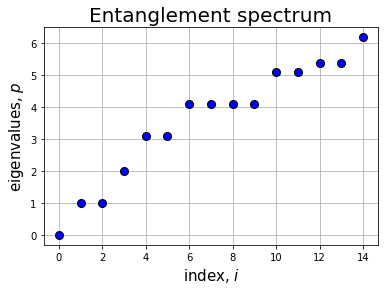

In [16]:
first = 15
plt.title(r"Entanglement spectrum", fontsize = 20)
plt.grid()
plt.ylabel(r"eigenvalues, $p$", fontsize = 15)
plt.xlabel(r"index, $i$", fontsize = 15)
plt.plot(Q[:first],  marker = "o", color = "b", ms=8, markeredgecolor= "black", ls='')
plt.show()

## 7.2. Free fermionic system: more zero-modes

We build a free fermion model with more zero modes. This will affect the ground-states and the universality class they belong to.

In [17]:
def build_matrix_A_g(N, a=-1): # bc=1 (default) for PBC and bc=-1 for APBC
    A = np.zeros((N, N)) 
    for n in range(N-1):
        A[n, n+1] = -1
        A[n+1, n] = -1
    A[N-1,0] = -1
    A[0,N-1] = -1
    
    for n in range(N-2):
        A[n,n+2] = -a
        A[n+2,n] = -a
    
    A[N-2,0] = -a
    A[N-1, 1] = -a
    A[0, N-2] = -a
    A[1, N-1] = -a
    return A

### 7.2.1. Energy

In [18]:
N = 100

A = build_matrix_A_g(N, -2)
T_op = build_T_operator(N, -1)

H = A.dot(np.eye(N) + 0.04*T_op)
D, U = eig(H)

e = np.real(np.diag((U.conj().T).dot(A).dot(U)))
k = np.angle(np.diag((U.conj().T).dot(T_op).dot(U)))

#sort from smaller to largest
ord_idx = np.argsort(e)
e = e[ord_idx]
k = k[ord_idx]
U = U[:,ord_idx]

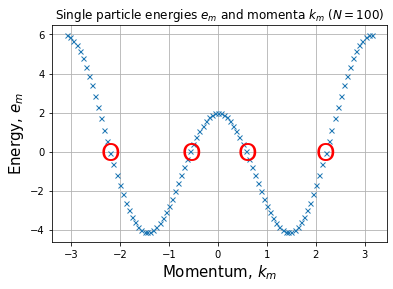

In [19]:
plt.title("Single particle energies $e_m$ and momenta $k_m$ ($N=$%s)" %(N))
plt.grid()
plt.ylabel(r"Energy, $e_m$", fontsize = 15)
plt.xlabel(r"Momentum, $k_m$", fontsize = 15)
plt.plot(k, e, 'x', ms=5)
plt.text(-2.40,-0.45,"O", fontsize=25, color='red')
plt.text(2,-0.45,"O", fontsize=25, color='red')
plt.text(-0.75,-0.45,"O", fontsize=25, color='red')
plt.text(0.4,-0.45,"O", fontsize=25, color='red')
plt.show()

### 7.2.2. Ground-state correlation matrix

In [20]:
M = (U.dot(np.diag(np.sign(e)))).dot(U.conj().T)
print("Is M successfully real?", np.allclose(M, np.real(M)))
M = np.real(M) #cleaning neglible imaginary part
print("Is M successfully symmetric?", np.allclose(M, (M+M.conj().T)/2))

L_max = 50
L_s = np.arange(1,L_max+1)
M_A = M[0:L_max, 0:L_max]

Is M successfully real? True
Is M successfully symmetric? True


### 7.2.3. Entanglement entropy in ground-state

In [21]:
def ent_entropy_fermi(M):
    p = np.shape(M)[0]
    enter = True
    entropy = np.zeros(p)
    for n in range(p+1):
        M_red = M[:n, :n]
        u,v = eig(M_red)
        for m in range(n):
            x = u[m]
            if abs(x) < 1:
                #print("correct")
                entropy[n-1] -= (1+x)/2*np.log2((1+x)/2) + (1-x)/2*np.log2((1-x)/2)
            elif abs(x) > 1+1e-8 and enter:
                print("warning: (absolute) single particle eigenvalue > 1")
                enter = False
    return entropy

In [22]:
entropy_numerical = ent_entropy_fermi(M_A)

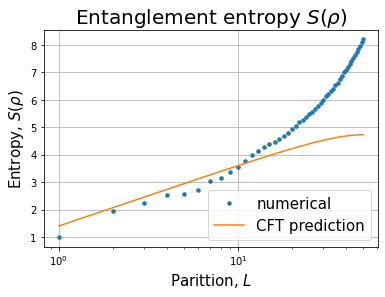

In [23]:
cft_ent_entropy = [2/3*(np.log2(N/np.pi*np.sin(n*np.pi/N)))+1.4 for n in L_s] #c = 2
plt.title(r"Entanglement entropy $S(\rho)$", fontsize = 20)
plt.xscale('log')
plt.grid()
plt.ylabel(r"Entropy, $S(\rho)$", fontsize = 15)
plt.xlabel(r"Parittion, $L$", fontsize = 15)
plt.plot(L_s, entropy_numerical, '.', ms=7, label = 'numerical')
plt.plot(L_s, cft_ent_entropy, label = 'CFT prediction')
plt.legend(loc = 'lower right', fontsize = 15)
plt.show()